In [ ]:
# Paper Title: Interpretability of Deep Models for Neuromimaging
# https://2022.midl.io/author-instructions.html

# https://www.mlforhc.org/paper-submission

# https://www.mdpi.com/journal/jimaging/special_issues/dlmia_ii



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd '/content/drive/MyDrive/Colab Notebooks/XMRI'

In [1]:
import os
import numpy as np
from pathlib import Path
import pandas as pd
import h5py
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score
from sklearn.decomposition import PCA
import time
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import plot_confusion_matrix
# from model import Models

In [6]:
# datapath = './Data/brainTumorDataPublic'

In [7]:
# files = [Path(datapath, x) for x in os.listdir(datapath) if x.endswith('.mat')]

In [8]:
def resize(x):
    return tf.keras.layers.experimental.preprocessing.Resizing(225, 225, interpolation='bilinear')(np.expand_dims(x,axis=-1))

In [9]:
CLASSES = {0 : "meningioma", 1 : "glioma", 2 : " pituitary tumor"}

In [10]:
def readData(files:list,outdir: str):
    """
     readData reads the stored .mat files that are passed as a list of strings, preprocess then as ndarray and write then to disk 
     as a compressed npz file
     
     :files is a list of file names that end with .mat extension to be processed
     :outdir is the output path for the compressed numpy array
    """
    X = []
    y = []
    for j in  tqdm(range(len(files))):
        f =  h5py.File(files[j],'r')
        data =  f.get('cjdata/image')
        # if(np.array(data).shape[0] == 512 and np.array(data).shape[1] == 512):
        X.append(np.array(resize(np.array(data))))
        label =  f.get('cjdata/label')
        label = int(np.squeeze(np.array(label)))
        y.append(label-1)
    np.savez(outdir, X = np.array(X), y = np.array(y),C=list(CLASSES.values()))
    print("Data has been processed successfully")

In [11]:
readData(files,outdir='./Data/brainTumorDataPublic.npz')

100%|██████████| 3157/3157 [01:47<00:00, 29.43it/s] 


Data has been processed successfully


In [3]:
data =  np.load('./Data/brainTumorDataPublic.npz',allow_pickle=True)
X =  data['X']
y = data['y']
CLASSES = list(data['C'])
X.shape

(3157, 225, 225, 1)

In [5]:
def plot_samples(X: np.ndarray,y: np.ndarray,CLASSES: list,idx,figsize=(8,8)):
    """ 
        plot_samples plots randomly selected samples from the dataset
        :X ndarray of the selected mri slices 
        : y ndarray of class labels 0 meningioma, 1 glioma, 2 pituitary tumor
        : CLASSES is a list of the above mentioned class strings 
        :idx ndarray of n sample indices
    """
    fig,axs = plt.subplots(4,4, figsize=figsize)
    fig.subplots_adjust(hspace=.5, wspace=.001)
    for i, ax in zip(list(range(0,len(idx))),axs.ravel()):
        ax.imshow(np.squeeze(X[idx[i]]))
        ax.set_title(CLASSES[y[idx[i]]])
        ax.set_axis_off()
    plt.show()
    fig.savefig('./Figures/Samples.svg',bbox_inches ="tight",dpi=300)

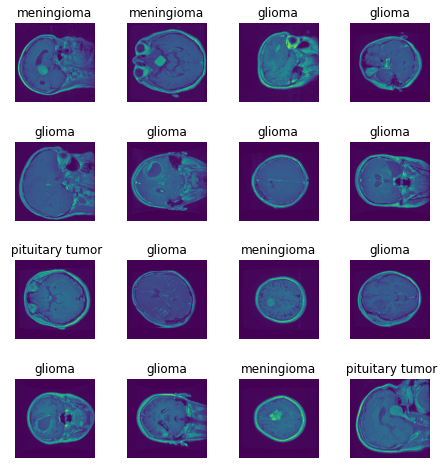

In [6]:
idx = np.random.randint(0, X.shape[0],16)
plot_samples(X,y,CLASSES,idx)

In [9]:
idx = np.random.randint(0, X.shape[0],100)

In [4]:
# X_ = np.divide((X[idx] - X[idx].mean(axis=0)), X[idx].std(axis=0), out=np.zeros_like((X[idx] - X[idx].mean(axis=0))), where=X[idx].std(axis=0)!=0)

X_ = np.divide((X - X.mean(axis=0)), X.std(axis=0), out=np.zeros_like((X - X.mean(axis=0))), where=X.std(axis=0)!=0)

In [8]:
pca = PCA(n_components=2)
X_pca =  pca.fit_transform(X_.reshape(X_.shape[0],-1).astype('float64'))

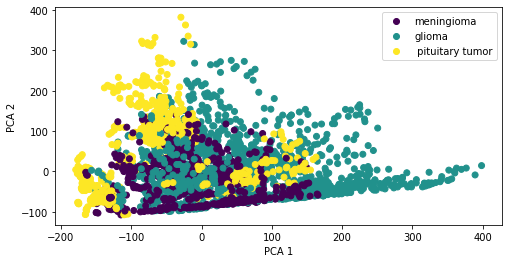

In [9]:
# #plotting results
fig = plt.figure(1,figsize=(8,4))
scatter = plt.scatter(X_pca[:,0],X_pca[:,1], c=list(y))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES,bbox_to_anchor=(1.0, 1.0))
plt.savefig('./Figures/XMRI_PCA.svg', bbox_inches ="tight", dpi=300)
plt.show()

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_,y, test_size=0.1, shuffle=True)

In [5]:
from tensorflow.keras.applications import VGG16,VGG19, ResNet50,InceptionV3,Xception
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras as keras
MODELS = [VGG16,VGG19, ResNet50,Xception]

In [13]:
def build_model(Model,input_shape, num_classes):
    K.clear_session() # Clear previous models from memory.
    base_model = Model(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=x, name = base_model.name)
    optim_params = dict(learning_rate = 0.001,momentum = 0.9394867962846013,decay = 0.0003)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(**optim_params),metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
    return model

In [14]:
def train_model(MODELS,X_train,X_test,y_train,y_test,input_shape,output_nums,CLASSES,n=10):
    hist = {'model':[], 'accuracy': [],'f1_score':[], 'time':[]}
    for j in  tqdm(range(len(MODELS))):
        model =  build_model(MODELS[j], input_shape, output_nums)
        print(f"We are training {model.name}")
        print("====================================================================")
        start = time.time()
        _ =  model.fit(x = X_train, y =y_train, epochs=n, validation_split = 0.1 )
        stop = time.time()
        y_pred = np.argmax(model.predict(X_test), axis = 1)
        hist['model'].append(model.name)
        hist['accuracy'].append(accuracy_score(y_test, y_pred))
        hist['f1_score'].append(f1_score(y_test, y_pred, average='micro'))
        hist['time'].append(stop - start)
        plot_confusion_matrix(y_test, y_pred,CLASSES, save=True,filename=f"{model.name}_plot_confusion_matrix.png" )
        model.save(f'./Models/{model.name}')
    return pd.DataFrame(hist)

In [15]:
dft = train_model(MODELS,X_train,X_test,y_train,y_test,X_train.shape[1:],len(CLASSES),CLASSES,n=10)

  0%|          | 0/4 [00:00<?, ?it/s]

We are training vgg16
Epoch 1/10
80/80 [==============================] - 92s 1s/step - loss: 1.0727 - accuracy: 0.4628 - val_loss: 1.0669 - val_accuracy: 0.4316
Epoch 2/10
80/80 [==============================] - 70s 874ms/step - loss: 1.0146 - accuracy: 0.4695 - val_loss: 0.9474 - val_accuracy: 0.4632
Epoch 3/10
80/80 [==============================] - 70s 876ms/step - loss: 0.7967 - accuracy: 0.6518 - val_loss: 0.7155 - val_accuracy: 0.6807
Epoch 4/10
80/80 [==============================] - 70s 875ms/step - loss: 0.6585 - accuracy: 0.7101 - val_loss: 0.6529 - val_accuracy: 0.7158
Epoch 5/10
80/80 [==============================] - 70s 879ms/step - loss: 0.6008 - accuracy: 0.7316 - val_loss: 0.5169 - val_accuracy: 0.7754
Epoch 6/10
80/80 [==============================] - 70s 878ms/step - loss: 0.5043 - accuracy: 0.7805 - val_loss: 0.5043 - val_accuracy: 0.7509
Epoch 7/10
80/80 [==============================] - 70s 877ms/step - loss: 0.4452 - accuracy: 0.8087 - val_loss: 0.4660 - v

 25%|██▌       | 1/4 [12:33<37:40, 753.63s/it]

We are training vgg19
Epoch 1/10
80/80 [==============================] - 83s 1s/step - loss: 1.0709 - accuracy: 0.4691 - val_loss: 1.0610 - val_accuracy: 0.4316
Epoch 2/10
80/80 [==============================] - 82s 1s/step - loss: 0.9419 - accuracy: 0.5203 - val_loss: 0.8246 - val_accuracy: 0.6281
Epoch 3/10
80/80 [==============================] - 82s 1s/step - loss: 0.7828 - accuracy: 0.6737 - val_loss: 0.6983 - val_accuracy: 0.6842
Epoch 4/10
80/80 [==============================] - 82s 1s/step - loss: 0.6371 - accuracy: 0.7222 - val_loss: 0.5735 - val_accuracy: 0.7439
Epoch 5/10
80/80 [==============================] - 82s 1s/step - loss: 0.5777 - accuracy: 0.7414 - val_loss: 0.6394 - val_accuracy: 0.7404
Epoch 6/10
80/80 [==============================] - 82s 1s/step - loss: 0.5078 - accuracy: 0.7707 - val_loss: 0.4760 - val_accuracy: 0.7649
Epoch 7/10
80/80 [==============================] - 82s 1s/step - loss: 0.4576 - accuracy: 0.8048 - val_loss: 0.6060 - val_accuracy: 0.761

 50%|█████     | 2/4 [26:25<26:39, 799.79s/it]

We are training resnet50
Epoch 1/10
80/80 [==============================] - 74s 814ms/step - loss: 10.7568 - accuracy: 0.5055 - val_loss: 391.3668 - val_accuracy: 0.5333
Epoch 2/10
80/80 [==============================] - 60s 752ms/step - loss: 6.1893 - accuracy: 0.5630 - val_loss: 98.0300 - val_accuracy: 0.5895
Epoch 3/10
80/80 [==============================] - 60s 753ms/step - loss: 4.2331 - accuracy: 0.6033 - val_loss: 22.6598 - val_accuracy: 0.6421
Epoch 4/10
80/80 [==============================] - 60s 752ms/step - loss: 1.7550 - accuracy: 0.7097 - val_loss: 0.8272 - val_accuracy: 0.6140
Epoch 5/10
80/80 [==============================] - 60s 753ms/step - loss: 4.3395 - accuracy: 0.6624 - val_loss: 0.6513 - val_accuracy: 0.7333
Epoch 6/10
80/80 [==============================] - 60s 752ms/step - loss: 1.3278 - accuracy: 0.7441 - val_loss: 0.5386 - val_accuracy: 0.7579
Epoch 7/10
80/80 [==============================] - 60s 754ms/step - loss: 1.1976 - accuracy: 0.7629 - val_loss:

 75%|███████▌  | 3/4 [37:24<12:15, 735.62s/it]

We are training xception
Epoch 1/10
80/80 [==============================] - 120s 1s/step - loss: 0.5402 - accuracy: 0.7797 - val_loss: 1.0985 - val_accuracy: 0.4386
Epoch 2/10
80/80 [==============================] - 105s 1s/step - loss: 0.1782 - accuracy: 0.9323 - val_loss: 1.0924 - val_accuracy: 0.4316
Epoch 3/10
80/80 [==============================] - 105s 1s/step - loss: 0.0602 - accuracy: 0.9816 - val_loss: 1.0819 - val_accuracy: 0.4316
Epoch 4/10
80/80 [==============================] - 106s 1s/step - loss: 0.0180 - accuracy: 0.9973 - val_loss: 1.0605 - val_accuracy: 0.4316
Epoch 5/10
80/80 [==============================] - 105s 1s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.4351
Epoch 6/10
80/80 [==============================] - 105s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.8277 - val_accuracy: 0.6737
Epoch 7/10
80/80 [==============================] - 105s 1s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5190 - val_accur

100%|██████████| 4/4 [56:19<00:00, 844.77s/it]


In [16]:
dft.head()

,model,accuracy,f1_score,time
0,vgg16,0.794304,0.794304,743.477970
1,vgg19,0.841772,0.841772,823.695554
2,resnet50,0.768987,0.768987,628.355126
3,xception,0.958861,0.958861,1108.209386


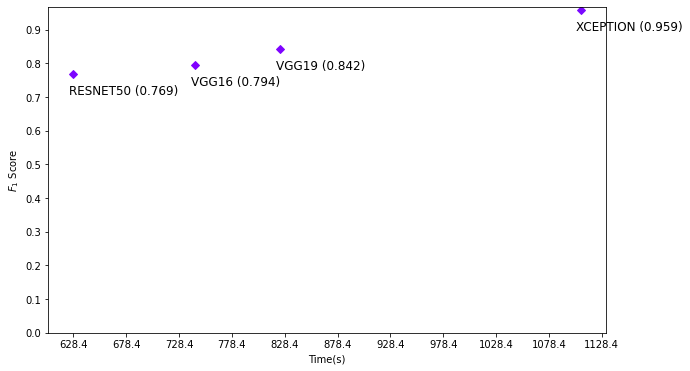

In [25]:
plt.figure(1,figsize=(10,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,dft.shape[0],1)]
for i in range(dft.shape[0]):
    plt.plot(dft.iloc[i][-1],dft.iloc[i][2], marker='D', color=colors[i])
    plt.annotate(fr"{dft.iloc[i][0].upper()} ({np.round(dft.iloc[i][2],3)})",(dft.iloc[i][-1]-4.0,dft.iloc[i][2]-0.06),fontsize=12)
plt.yticks(np.arange(0, 1, .1))
plt.xticks(np.arange(min(dft['time']), max(dft['time'])+50,50))
plt.ylabel(r'$F_1$ Score')
plt.xlabel('Time(s)')
# plt.grid()
plt.savefig(f'./Figures/Train_Time_Accuracy.svg', bbox_inches ="tight", dpi=300)
plt.show()

In [10]:
model = keras.models.load_model("./Models/xception")

In [7]:
repmodel  = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name = model.name)

In [13]:
del data

In [11]:
X_hat =  repmodel.predict(X_)

In [ ]:
# pca = PCA(n_components=2)
# X_pca =  pca.fit_transform(X_hat.astype('float64'))
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X_hat.astype('float64'))
# #plotting results
fig = plt.figure(1,figsize=(8,4))
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=list(y))
plt.xlabel(r'$x_1$')
plt.ylabel('$x_2$')
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES,bbox_to_anchor=(1.0, 1.0))
plt.savefig('./Figures/XMRI_PCA_After.svg', bbox_inches ="tight", dpi=300)
plt.show()

In [81]:
del X_hat 

# Salency Analysis

In [82]:
!pip install saliency

In [83]:
import PIL.Image
from matplotlib import pylab as P
# From our repository.
import saliency.core as saliency
import PIL.Image
%matplotlib inline

## Utility Methods

In [84]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  img = P.imshow(im)
  P.title(title,fontsize=10)
  # P.colorbar(img, ax=ax, orientation='vertical');

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  img = P.imshow(im)
  # P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title, fontsize=10)
  # P.colorbar(img, ax=ax, orientation='vertical');

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  img = P.imshow(im)
  # img = P.imshow(im, cmap='gray')
  P.title(title,fontsize=10)
  # P.colorbar(im, ax=ax, orientation='vertical');


def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

In [85]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

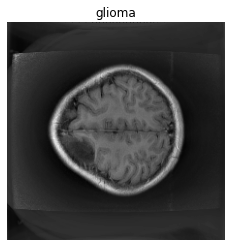

In [86]:
idx = np.random.randint(0,X_.shape[0]) 
im =  X_[idx]

plt.imshow(np.squeeze(im), cmap='gray')
plt.axis('off')
plt.title(CLASSES[y[idx]])
plt.show()

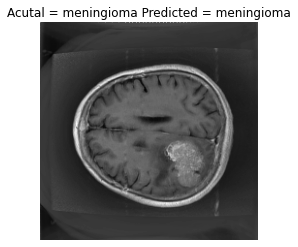

In [87]:
idx = np.random.randint(0,X_.shape[0]) 
im = X_[idx]
predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}
plt.imshow(np.squeeze(X_[idx]), cmap='gray')
plt.axis('off')
plt.title(f"Acutal = {CLASSES[y[idx]]} Predicted = {CLASSES[prediction_class]}")
plt.show()
# show_spec(X_test[0], prediction_class)
# print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

### Vanilla Gradient & SmoothGrad

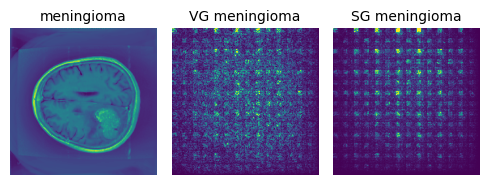

In [88]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 5
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR), dpi=100)

# Show original image
ShowImage(np.squeeze(im), title=f'{CLASSES[y[idx]]}', ax=P.subplot(ROWS, COLS, 1))


# Render the saliency masks.
#Vanilla Gradient VG
#Smooth Gradient SG
ShowGrayscaleImage(vanilla_mask_grayscale, title=f'VG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title=f'SG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 3))
P.tight_layout()
P.savefig(f'./Figures/VG_SG_{CLASSES[y[idx]]}.svg', bbox_inches ="tight", dpi=300)

### Integrated Gradients & SmoothGrad


In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 5
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR), dpi=100)

# Show original image
ShowImage(np.squeeze(im), title=f'{CLASSES[y[idx]]}', ax=P.subplot(ROWS, COLS, 1))

# Render the saliency masks.
#Vanilla Integrated Gradients VIG 
#Smoothgrad Integrated Gradients SIG
ShowGrayscaleImage(vanilla_mask_grayscale, title=f'VIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title=f'SIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 3))
P.tight_layout()
P.savefig(f'./Figures/VIG_SIG_{CLASSES[y[idx]]}.svg', bbox_inches ="tight", dpi=300)

### XRAI Full and Fast

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 6
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR), dpi=100)

# Show original image
ShowImage(np.squeeze(im), title=f'{CLASSES[y[idx]]}', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title=f'XRAI {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask =  np.array(im)
im_mask[~mask] = 0
ShowImage(np.squeeze(im_mask), title=f'Top 30% {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 3))
P.tight_layout()
P.savefig(f'./Figures/XRAI_{CLASSES[y[idx]]}.svg', bbox_inches ="tight", dpi=300)

### Guided IG


In [ ]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients()
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Guided IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 5
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR), dpi=100)

# Render the saliency masks.
#Vanilla Integrated Gradients VIG
#Guided Integrated Gradients
ShowImage(np.squeeze(im), title=f'{CLASSES[y[idx]]}', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title=f'VIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(guided_ig_mask_grayscale, title=f'GIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 3))
P.tight_layout()
P.savefig(f'./Figures/GIG_{CLASSES[y[idx]]}.svg', bbox_inches ="tight", dpi=300)

### Blur IG

In [ ]:
# Compare BlurIG and Smoothgrad with BlurIG. Note: This will take a long time to run.

# Construct the saliency object. This alone doesn't do anthing.
blur_ig = saliency.BlurIG()

# Compute the Blur IG mask and Smoothgrad+BlurIG mask.
blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
# Smoothed mask for BlurIG will take a while since we are doing nsamples * nsamples computations.
smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 5
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR), dpi=100)
# Show original image
ShowImage(np.squeeze(im), title=f'{CLASSES[y[idx]]}', ax=P.subplot(ROWS, COLS, 1))

# Render the saliency masks.
#Blur Integrated Gradients
#Smoothgrad Blur IG
ShowGrayscaleImage(blur_ig_mask_grayscale, title=f'BIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title=f'SBIG {CLASSES[y[idx]].replace("_", " ")}', ax=P.subplot(ROWS, COLS, 3))
P.tight_layout()
P.savefig(f'./Figures/SBIG_{CLASSES[y[idx]]}.svg', bbox_inches ="tight", dpi=300)